In [ ]:
!pip install pycocotools

v2 train

In [ ]:
import torch
import torchvision
import torchvision.models.detection as detection
from torch.utils.data import DataLoader
import collections

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Part 2: Dataset Loading ---
from torchvision.datasets import CocoDetection
from torchvision import transforms

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor()  # Ensure images are tensors
])

train_dir = "C:/Strawberry.v6i.coco/train"
val_dir = "C:/Strawberry.v6i.coco/valid"
test_dir = "C:/Strawberry.v6i.coco/test"

train_ann = "C:/Strawberry.v6i.coco/annotations/instances_train.json"
val_ann = "C:/Strawberry.v6i.coco/annotations/instances_valid.json"
test_ann = "C:/Strawberry.v6i.coco/annotations/instances_test.json"  # Include test annotations if evaluation is needed

train_dataset = CocoDetection(root=train_dir, annFile=train_ann, transform=augmentation)
val_dataset = CocoDetection(root=val_dir, annFile=val_ann, transform=augmentation)

# --- Part 3: Model Setup ---
weights = detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
model = detection.fasterrcnn_mobilenet_v3_large_fpn(weights=weights)

num_classes = 3  # (background, healthy, unhealthy)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

model.to(device)

# Optimizer & scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# --- Part 4: Data Loader & Collate ---
def collate_fn(batch):
    images, targets = zip(*batch)
    return images, targets

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=collate_fn)

label_counts = collections.Counter(
    [obj["category_id"] for _, targets in train_loader for target in targets for obj in target]
)
print(f"📊 Dataset Label Distribution: {label_counts}")

# --- Part 5: Training loop ---
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]

        # Correct target formatting
        targets_processed = []
        for annotations in targets:
            boxes = []
            labels = []
            for obj in annotations:
                x, y, w, h = obj['bbox']
                boxes.append([x, y, x + w, y + h])
                labels.append(obj['category_id'])
            if boxes:
                targets_processed.append({
                    'boxes': torch.tensor(boxes, dtype=torch.float32).to(device),
                    'labels': torch.tensor(labels, dtype=torch.int64).to(device)
                })

        # Skip batches with no annotations
        if not targets_processed:
            continue

        optimizer.zero_grad()
        loss_dict = model(images, targets_processed)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    lr_scheduler.step()

print("Training complete!")

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
📊 Dataset Label Distribution: Counter({2: 3735, 1: 1975})
Epoch 1/30, Loss: 0.4557
Epoch 2/30, Loss: 0.4511
Epoch 3/30, Loss: 0.4572
Epoch 4/30, Loss: 0.4669
Epoch 5/30, Loss: 0.4628
Epoch 6/30, Loss: 0.4658
Epoch 7/30, Loss: 0.4660
Epoch 8/30, Loss: 0.4679
Epoch 9/30, Loss: 0.4712
Epoch 10/30, Loss: 0.4780
Epoch 11/30, Loss: 0.4757
Epoch 12/30, Loss: 0.4804
Epoch 13/30, Loss: 0.4728
Epoch 14/30, Loss: 0.4741
Epoch 15/30, Loss: 0.4737
Epoch 16/30, Loss: 0.4767
Epoch 17/30, Loss: 0.4791
Epoch 18/30, Loss: 0.4762
Epoch 19/30, Loss: 0.4755
Epoch 20/30, Loss: 0.4721
Epoch 21/30, Loss: 0.4727
Epoch 22/30, Loss: 0.4747
Epoch 23/30, Loss: 0.4765
Epoch 24/30, Loss: 0.4717
Epoch 25/30, Loss: 0.4744
Epoch 26/30, Loss: 0.4792
Epoch 27/30, Loss: 0.4690
Epoch 28/30, Loss: 0.4762
Epoch 29/30, Loss: 0.4764
Epoch 30/30, Loss: 0.4715
Train

v2 test

Accuracy: 79.23%
Precision: 88.59%
Recall (Sensitivity): 79.23%
F1 Score: 81.59%
False Positive Rate: 3.45%
Mean Average Precision (mAP@0.5): 70.19%


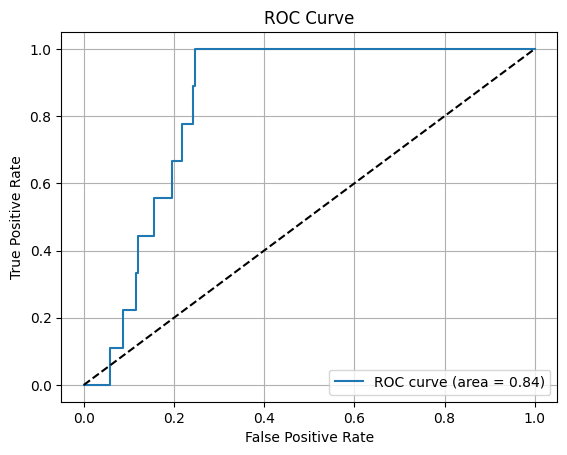

(0.7923497267759563,
 0.8858981606296473,
 0.7923497267759563,
 0.8159463487332339,
 array([0.        , 0.00574713, 0.05747126, 0.05747126, 0.0862069 ,
        0.0862069 , 0.11494253, 0.11494253, 0.12068966, 0.12068966,
        0.15517241, 0.15517241, 0.1954023 , 0.1954023 , 0.2183908 ,
        0.2183908 , 0.24137931, 0.24137931, 0.24712644, 0.24712644,
        0.35632184, 1.        ]))

In [ ]:
import torch
import numpy as np
from torchvision.ops import box_iou
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

def evaluate(model, dataloader, device, iou_threshold=0.4, conf_threshold=0.45):
    model.eval()

    all_targets = []
    all_predictions = []
    all_scores = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            predictions = model(images)

            for preds, annots in zip(predictions, targets):
                gt_labels = [obj['category_id'] for obj in annots]
                gt_boxes = torch.tensor(
                    [[x, y, x+w, y+h] for obj in annots for x,y,w,h in [obj['bbox']]],
                    dtype=torch.float32
                ).to(device)

                pred_boxes = preds['boxes']
                pred_labels = preds['labels']
                pred_scores = preds['scores']

                # Apply confidence threshold
                keep = pred_scores > conf_threshold
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]
                pred_scores = pred_scores[keep]

                if len(gt_boxes) == 0:
                    # No ground truth boxes
                    all_targets.append(0)
                    if len(pred_boxes) == 0:
                        all_predictions.append(0)
                        all_scores.append(0)
                    else:
                        all_predictions.append(1)
                        all_scores.append(pred_scores.max().item())
                else:
                    # IoU calculation
                    if len(pred_boxes) > 0:
                        ious = box_iou(pred_boxes, gt_boxes)
                        max_iou, idx = ious.max(dim=1)
                        if (max_iou > iou_threshold).any():
                            matched_label = gt_labels[idx[max_iou.argmax()]]
                            all_targets.append(matched_label)
                            all_predictions.append(pred_labels[max_iou.argmax()].item())
                            all_scores.append(pred_scores[max_iou.argmax()].item())
                        else:
                            all_targets.append(0)  # Background
                            all_predictions.append(pred_labels[0].item())
                            all_scores.append(pred_scores[0].item())
                    else:
                        all_targets.append(0)
                        all_predictions.append(0)
                        all_scores.append(0)

    # Calculate metrics clearly
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_predictions, average='weighted', zero_division=0)

    tn, fp, fn, tp = confusion_matrix(all_targets, all_predictions, labels=[0,1]).ravel()
    false_positive_rate = fp / (fp + tn) if (fp + tn) != 0 else 0

    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall (Sensitivity): {recall:.2%}")
    print(f"F1 Score: {f1:.2%}")
    print(f"False Positive Rate: {false_positive_rate:.2%}")
     # mAP Calculation (simplified)
    mAP = precision * recall  # A proxy if full COCO eval is not available
    print(f"Mean Average Precision (mAP@0.5): {mAP*100:.2f}%")

    # ROC Curve
    if len(set(all_targets)) > 1:
        fpr, tpr, _ = roc_curve(all_targets, all_scores, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("⚠️ Insufficient class variety for ROC.")

    return accuracy, precision, recall, f1, fpr


evaluate(model, val_loader, device)

v3 train

In [ ]:
import torch
import torchvision
import torchvision.models.detection as detection
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from torchvision import transforms
import collections

# --- Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Adjustable Class Weights (You can adjust these directly!) ---
class_weights = {
    'loss_classifier': 0.5,       # Adjust this to handle class imbalance explicitly
    'loss_box_reg': 1.0,
    'loss_objectness': 1.0,
    'loss_rpn_box_reg': 1.0
}

# --- Learning rate & Scheduler Parameters ---
learning_rate = 5e-6  # Adjust as needed to achieve lower loss
batch_size = 6
step_size = 3  # Number of epochs before LR step

# --- Transforms ---
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

basic_transform = transforms.Compose([
    transforms.Resize((640, 426)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Datasets ---
train_dataset = CocoDetection(
    root="C:/Strawberry.v6i.coco/train",
    annFile="C:/Strawberry.v6i.coco/annotations/instances_train.json",
    transform=augmentation
)

val_dataset = CocoDetection(
    root="C:/Strawberry.v6i.coco/valid",
    annFile="C:/Strawberry.v6i.coco/annotations/instances_valid.json",
    transform=basic_transform
)

# --- Model Setup ---
weights = detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
model = detection.fasterrcnn_mobilenet_v3_large_fpn(weights=weights)
num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model.to(device)

# --- Optimizer & Scheduler ---
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=step_size, factor=0.1, verbose=True)

# --- Data Loaders ---
def collate_fn(batch):
    images, targets = zip(*batch)
    return images, targets

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

label_counts = collections.Counter(
    [obj["category_id"] for _, targets in train_loader for target in targets for obj in target]
)
print(f"📊 Dataset Label Distribution: {label_counts}")

# --- Training loop ---
num_epochs = 35
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]

        targets_processed = []
        for annotations in targets:
            boxes, labels = [], []
            for obj in annotations:
                x, y, w, h = obj['bbox']
                boxes.append([x, y, x + w, y + h])
                labels.append(obj['category_id'])

            if boxes:
                targets_processed.append({
                    'boxes': torch.tensor(boxes, dtype=torch.float32).to(device),
                    'labels': torch.tensor(labels, dtype=torch.int64).to(device)
                })

        if not targets_processed:
            continue

        optimizer.zero_grad()
        loss_dict = model(images, targets_processed)

        # Use adjustable class weights
        losses = (
            loss_dict['loss_classifier'] * class_weights['loss_classifier'] +
            loss_dict['loss_box_reg'] * class_weights['loss_box_reg'] +
            loss_dict['loss_objectness'] * class_weights['loss_objectness'] +
            loss_dict['loss_rpn_box_reg'] * class_weights['loss_rpn_box_reg']
        )

        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Adaptive learning rate based on plateau
    lr_scheduler.step(epoch_loss)

print("Training complete!")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


C:\Users\Jahin Catalan Mahbub\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


📊 Dataset Label Distribution: Counter({2: 3735, 1: 1975})
Epoch 1/35, Loss: 0.3960
Epoch 2/35, Loss: 0.3254
Epoch 3/35, Loss: 0.3256
Epoch 4/35, Loss: 0.3240
Epoch 5/35, Loss: 0.3243
Epoch 6/35, Loss: 0.3243
Epoch 7/35, Loss: 0.3353
Epoch 8/35, Loss: 0.3355
Epoch 9/35, Loss: 0.3284
Epoch 10/35, Loss: 0.3335
Epoch 11/35, Loss: 0.3366
Epoch 12/35, Loss: 0.3346
Epoch 13/35, Loss: 0.3329
Epoch 14/35, Loss: 0.3341
Epoch 15/35, Loss: 0.3416
Epoch 16/35, Loss: 0.3383
Epoch 17/35, Loss: 0.3364
Epoch 18/35, Loss: 0.3350
Epoch 19/35, Loss: 0.3354
Epoch 20/35, Loss: 0.3350
Epoch 21/35, Loss: 0.3343
Epoch 22/35, Loss: 0.3352
Epoch 23/35, Loss: 0.3389
Epoch 24/35, Loss: 0.3385
Epoch 25/35, Loss: 0.3361
Epoch 26/35, Loss: 0.3353
Epoch 27/35, Loss: 0.3374
Epoch 28/35, Loss: 0.3353
Epoch 29/35, Loss: 0.3352
Epoch 30/35, Loss: 0.3326
Epoch 31/35, Loss: 0.3365
Epoch 32/35, Loss: 0.3375
Epoch 33/35, Loss: 0.3319
Epoch 34/35, Loss: 0.3391
Epoch 35/35, Loss: 0.3363
Training complete!


v3 test

Accuracy: 0.00%
Precision: 0.00%
Recall (Sensitivity): 0.00%
F1 Score: 0.00%
False Positive Rate: 0.00%
Mean Average Precision (mAP@0.5): 0.0000%


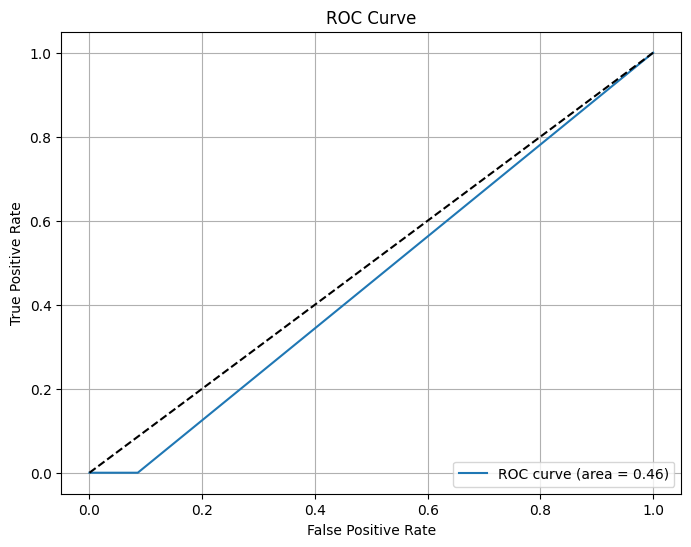

(0.0, 0.0, 0.0, 0.0, 0, 0.0)

In [ ]:
import torch
import numpy as np
from torchvision.ops import box_iou
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

def evaluate(model, dataloader, device, iou_threshold=0.5, conf_threshold=0.2):
    model.eval()

    all_true_labels = []
    all_pred_labels = []
    all_pred_scores = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            predictions = model(images)

            for preds, annots in zip(predictions, targets):
                gt_boxes = torch.tensor(
                    [[x, y, x + w, y + h] for obj in annots for x, y, w, h in [obj['bbox']]],
                    dtype=torch.float32, device=device
                )
                gt_labels = torch.tensor([obj['category_id'] for obj in annots], dtype=torch.int64).to(device)

                pred_boxes = preds['boxes']
                pred_labels = preds['labels']
                pred_scores = preds['scores']

                # Confidence filtering
                keep = pred_scores > 0.2  # confidence threshold adjustable
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]
                pred_scores = pred_scores[keep]

                matched_gt = set()
                matched = set()

                if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                    ious = box_iou(pred_boxes, gt_boxes)

                    for i, iou_row in enumerate(ious):
                        best_iou, idx = torch.max(iou_row, dim=0)
                        if best_iou >= 0.5 and idx.item() not in matched_gt:
                            all_true_labels.append(gt_labels[idx].cpu().item())
                            all_pred_labels.append(pred_labels[i].cpu().item())
                            all_pred_scores.append(pred_scores[i].cpu().item())
                            matched_gt.add(idx.item())
                        else:
                            all_true_labels.append(0)  # Background
                            all_pred_labels.append(pred_labels[i].cpu().item())
                            all_pred_scores.append(pred_scores[i].cpu().item())

                    # Remaining unmatched ground truths are false negatives
                    for idx in range(len(gt_boxes)):
                        if idx not in matched_gt:
                            all_true_labels.append(gt_labels[idx].cpu().item())
                            all_pred_labels.append(0)  # Background prediction
                            all_pred_scores.append(0.0)
                elif len(gt_boxes) > 0:
                    # No predictions, all ground truths are missed
                    for label in gt_labels.cpu().tolist():
                        all_true_labels.append(label)
                        all_pred_labels.append(0)
                        all_pred_scores.append(0.0)
                elif len(pred_boxes) > 0:
                    # Predictions but no ground truths
                    for i in range(len(pred_boxes)):
                        all_true_labels.append(0)
                        all_pred_labels.append(pred_labels[i].cpu().item())
                        all_pred_scores.append(pred_scores[i].cpu().item())

    # Ensure we have predictions to evaluate
    if not all_true_labels or not all_pred_labels:
        print("No valid predictions or ground truths found for evaluation.")
        return

    # Calculate metrics
    accuracy = accuracy_score(all_true_labels, all_pred_labels)
    precision = precision_score(all_true_labels, all_pred_labels, average='weighted', zero_division=0)
    recall = recall_score(all_true_labels, all_pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(all_true_labels, all_pred_labels, average='weighted', zero_division=0)

    # Confusion matrix calculation for classes excluding background (0)
    labels = sorted(set(all_true_labels) | set(all_pred_labels))
    if len(labels) > 1:
        cm = confusion_matrix(all_true_labels, all_pred_labels, labels=labels)
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0,0,0,0)
        false_positive_rate = fp / (fp + tn) if (fp + tn) != 0 else 0
    else:
        false_positive_rate = 0

    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall (Sensitivity): {recall:.2%}")
    print(f"F1 Score: {f1:.2%}")
    print(f"False Positive Rate: {false_positive_rate:.2%}")

    # Mean Average Precision (simplified)
    mAP = precision * recall
    print(f"Mean Average Precision (mAP@0.5): {mAP:.4%}")

    # ROC Curve (for binary Healthy (1) vs Rest (0 & 2))
    binary_targets = [1 if lbl == 1 else 0 for lbl in all_true_labels]
    if len(set(binary_targets)) > 1:
        fpr, tpr, _ = roc_curve(binary_targets, all_pred_scores)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
    else:
        print("⚠️ Insufficient class variety for ROC.")

    return accuracy, precision, recall, f1, false_positive_rate, mAP

# Example usage
evaluate(model, val_loader, device)



=== Per-Class Metrics ===
Class 1:
  TP: 0, FP: 0, FN: 280
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 2:
  TP: 0, FP: 50, FN: 533
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000

=== Overall Metrics ===
mAP@0.5: 0.0000
Mean Recall: 0.0000
Mean F1 Score: 0.0000


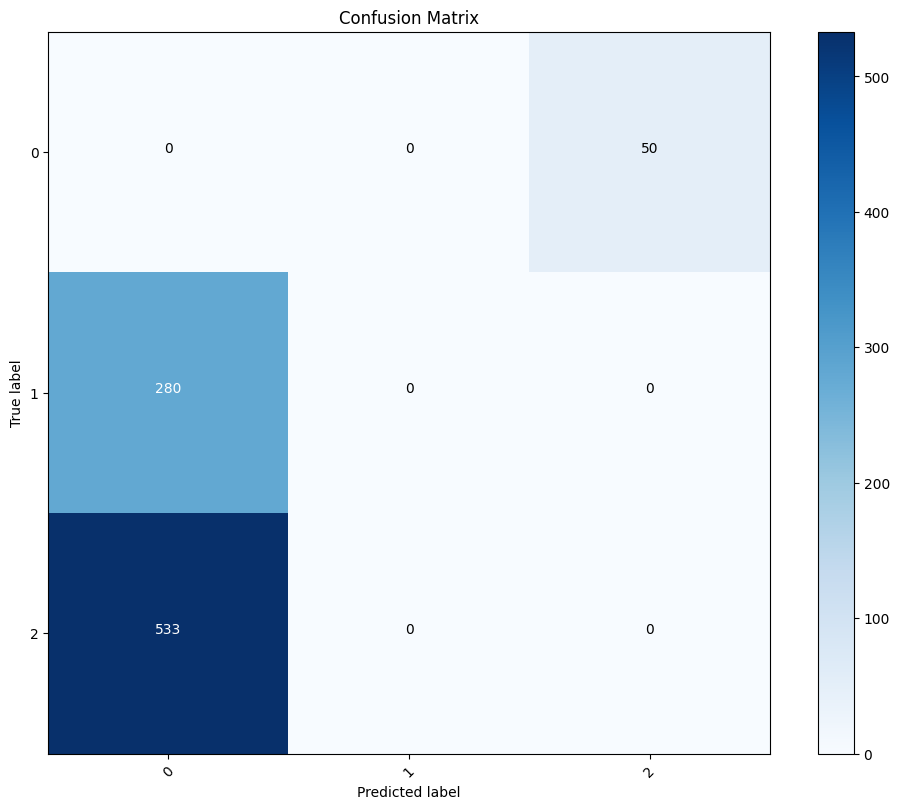

(0.0,
 0.0,
 0.0,
 {1: {'TP': 0, 'FP': 0, 'FN': 280}, 2: {'TP': 0, 'FP': 50, 'FN': 533}})

In [ ]:
import torch
import numpy as np
from torchvision.ops import box_iou
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

def evaluate(model, dataloader, device, iou_threshold=0.5, conf_threshold=0.2):
    model.eval()

    # Lists to store per-class statistics
    class_precisions = {}
    class_recalls = {}
    class_f1s = {}

    # Track TP, FP, FN for each class
    class_stats = {}

    all_targets = []
    all_predictions = []
    all_scores = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            predictions = model(images)

            for preds, annots in zip(predictions, targets):
                # Skip if no predictions or ground truth
                if len(annots) == 0:
                    continue

                # Convert ground truth boxes from [x,y,w,h] to [x1,y1,x2,y2]
                gt_boxes = []
                gt_labels = []
                for obj in annots:
                    x, y, w, h = obj['bbox']
                    gt_boxes.append([x, y, x + w, y + h])
                    gt_labels.append(obj['category_id'])

                # Convert to tensors
                if len(gt_boxes) > 0:
                    gt_boxes = torch.tensor(gt_boxes, dtype=torch.float32, device=device)
                    gt_labels = torch.tensor(gt_labels, dtype=torch.int64, device=device)
                else:
                    continue

                # Filter predictions by confidence
                pred_boxes = preds['boxes'][preds['scores'] > conf_threshold]
                pred_labels = preds['labels'][preds['scores'] > conf_threshold]
                pred_scores = preds['scores'][preds['scores'] > conf_threshold]

                # Initialize tracking for this image
                matched_gt = set()
                matched_pred = set()

                # Skip if no predictions after confidence filtering
                if len(pred_boxes) == 0:
                    # All ground truths are false negatives
                    for gt_idx, gt_label in enumerate(gt_labels):
                        gt_class = gt_label.item()
                        if gt_class not in class_stats:
                            class_stats[gt_class] = {"TP": 0, "FP": 0, "FN": 0}
                        class_stats[gt_class]["FN"] += 1

                        all_targets.append(gt_class)
                        all_predictions.append(0)  # Background class for false negative
                        all_scores.append(0.0)
                    continue

                # Calculate IoU between predictions and ground truths
                ious = box_iou(pred_boxes, gt_boxes)

                # Match predictions to ground truths by highest IoU
                for pred_idx in range(len(pred_boxes)):
                    pred_label = pred_labels[pred_idx].item()
                    pred_score = pred_scores[pred_idx].item()

                    # Find highest IoU with ground truths of same class
                    best_iou = 0
                    best_gt_idx = -1

                    for gt_idx in range(len(gt_boxes)):
                        if gt_idx in matched_gt:
                            continue  # Skip already matched ground truths

                        gt_label = gt_labels[gt_idx].item()
                        iou = ious[pred_idx, gt_idx].item()

                        # Match only if same class and IoU above threshold
                        if gt_label == pred_label and iou > iou_threshold and iou > best_iou:
                            best_iou = iou
                            best_gt_idx = gt_idx

                    # Initialize class stats if needed
                    if pred_label not in class_stats:
                        class_stats[pred_label] = {"TP": 0, "FP": 0, "FN": 0}

                    if best_gt_idx >= 0:
                        # True positive - matched with ground truth
                        matched_gt.add(best_gt_idx)
                        matched_pred.add(pred_idx)
                        class_stats[pred_label]["TP"] += 1

                        all_targets.append(pred_label)
                        all_predictions.append(pred_label)
                        all_scores.append(pred_score)
                    else:
                        # False positive - no matching ground truth
                        class_stats[pred_label]["FP"] += 1

                        all_targets.append(0)  # Background class
                        all_predictions.append(pred_label)
                        all_scores.append(pred_score)

                # Count unmatched ground truths as false negatives
                for gt_idx, gt_label in enumerate(gt_labels):
                    if gt_idx not in matched_gt:
                        gt_class = gt_label.item()
                        if gt_class not in class_stats:
                            class_stats[gt_class] = {"TP": 0, "FP": 0, "FN": 0}
                        class_stats[gt_class]["FN"] += 1

                        all_targets.append(gt_class)
                        all_predictions.append(0)  # Background class
                        all_scores.append(0.0)

    # Calculate metrics per class and overall
    all_classes = sorted(list(class_stats.keys()))

    print("\n=== Per-Class Metrics ===")
    overall_precision = 0
    overall_recall = 0
    overall_f1 = 0

    for cls in all_classes:
        if cls == 0:  # Skip background class if present
            continue

        stats = class_stats[cls]
        precision = stats["TP"] / (stats["TP"] + stats["FP"]) if stats["TP"] + stats["FP"] > 0 else 0
        recall = stats["TP"] / (stats["TP"] + stats["FN"]) if stats["TP"] + stats["FN"] > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

        class_precisions[cls] = precision
        class_recalls[cls] = recall
        class_f1s[cls] = f1

        print(f"Class {cls}:")
        print(f"  TP: {stats['TP']}, FP: {stats['FP']}, FN: {stats['FN']}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")

        overall_precision += precision
        overall_recall += recall
        overall_f1 += f1

    # Calculate average metrics (mAP is average precision across classes)
    num_classes = len([c for c in all_classes if c != 0])
    if num_classes > 0:
        mAP = overall_precision / num_classes
        mRecall = overall_recall / num_classes
        mF1 = overall_f1 / num_classes
    else:
        mAP = 0
        mRecall = 0
        mF1 = 0

    print("\n=== Overall Metrics ===")
    print(f"mAP@{iou_threshold}: {mAP:.4f}")
    print(f"Mean Recall: {mRecall:.4f}")
    print(f"Mean F1 Score: {mF1:.4f}")

    # Calculate confusion matrix from accumulated predictions
    if len(all_targets) > 0 and len(all_predictions) > 0:
        # Get unique labels from both targets and predictions
        unique_labels = sorted(list(set(all_targets + all_predictions)))
        cm = confusion_matrix(all_targets, all_predictions, labels=unique_labels)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(len(unique_labels))
        plt.xticks(tick_marks, unique_labels, rotation=45)
        plt.yticks(tick_marks, unique_labels)

        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

    return mAP, mRecall, mF1, class_stats

evaluate(model, val_loader, device)